In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
market_data = pd.read_csv("./data/Bitcoin Price Weekly 2022 to 2010 .csv")
graph_parameters= pd.read_csv("./data/weeklyparameters.csv")
scaler = StandardScaler()
graph_parameters = pd.DataFrame(scaler.fit_transform(graph_parameters))

In [5]:
full_df= pd.concat([market_data.iloc[50:50+graph_parameters.shape[0],1:].reset_index().drop('index',axis=1),graph_parameters],axis=1).iloc[:116]

In [6]:
threshold=3
def y_creator(threshold):
    Y = []
    for i in market_data["Change %"][51:51+graph_parameters.shape[0]]:
        if abs(i)>threshold:
            if i>0:
                Y.append(1)
            else:
                Y.append(-1)
        else:
            Y.append(0)
    return Y
Y = y_creator(threshold)

In [7]:
scaler = StandardScaler()
scaled_x = scaler.fit_transform(full_df)
x_train, x_test, y_train, y_test = train_test_split(scaled_x, Y, test_size=0.33, random_state=42)

In [8]:
averages = ["macro", "micro","weighted"]

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_model           = svm.SVC()
param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_model, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(x_train, y_train)
print(rnd_search_cv.best_score_)
print(rnd_search_cv.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=7.207401114066028, gamma=0.007446747356106111; total time=   0.0s
[CV] END ....C=7.207401114066028, gamma=0.007446747356106111; total time=   0.0s
[CV] END ....C=7.207401114066028, gamma=0.007446747356106111; total time=   0.0s
[CV] END .....C=4.867660727363225, gamma=0.05171700141115569; total time=   0.0s
[CV] END .....C=4.867660727363225, gamma=0.05171700141115569; total time=   0.0s
[CV] END .....C=4.867660727363225, gamma=0.05171700141115569; total time=   0.0s
[CV] END ....C=6.450546191268726, gamma=0.009132421973957291; total time=   0.0s
[CV] END ....C=6.450546191268726, gamma=0.009132421973957291; total time=   0.0s
[CV] END ....C=6.450546191268726, gamma=0.009132421973957291; total time=   0.0s
[CV] END .....C=6.32452259694126, gamma=0.008808719545664583; total time=   0.0s
[CV] END .....C=6.32452259694126, gamma=0.008808719545664583; total time=   0.0s
[CV] END .....C=6.32452259694126, gamma=0.008808

In [10]:
svm_hyperparameters = (rnd_search_cv.best_estimator_.C, rnd_search_cv.best_estimator_.gamma)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    3.0s remaining:    9.2s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    3.0s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:    3.0s remaining:    1.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:    3.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    3.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.0s


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    1.7s finished


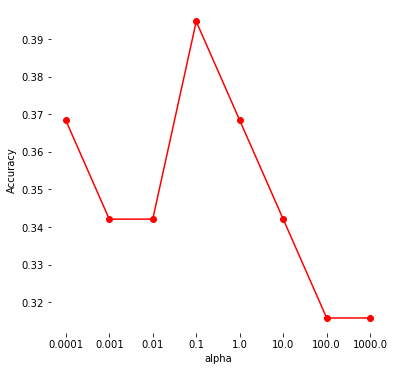

SGDClassifier(alpha=0.1, loss='log', n_jobs=-1) 0.39473684210526316


In [11]:
from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
import parfit.parfit as pf

grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}
paramGrid = ParameterGrid(grid)

bestModel, bestScore, allModels, allScores = pf.bestFit(SGDClassifier, paramGrid,
           x_train, y_train, x_test, y_test, 
           metric = accuracy_score,
           scoreLabel = "Accuracy")

print(bestModel, bestScore)

In [12]:
scd_hyperparameters = (bestModel.alpha, bestModel.loss, bestModel.n_jobs)

In [13]:
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = GridSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(x_train,y_train)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 1
Best p: 1
Best n_neighbors: 16


In [14]:
knn_hyperparameters = (best_model.best_estimator_.get_params()["leaf_size"], best_model.best_estimator_.get_params()["p"], best_model.best_estimator_.get_params()["n_neighbors"])

In [15]:
dec_tree = DecisionTreeClassifier()
std_slc = StandardScaler()
pipe = Pipeline(steps=[('std_slc', std_slc),
                           ('dec_tree', dec_tree)])
n_components = list(range(1,len(x_train)+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12]
parameters = dict( dec_tree__criterion=criterion,
                      dec_tree__max_depth=max_depth)

In [16]:
clf_GS = GridSearchCV(pipe, parameters)
clf_GS.fit(x_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('std_slc', StandardScaler()),
                                       ('dec_tree', DecisionTreeClassifier())]),
             param_grid={'dec_tree__criterion': ['gini', 'entropy'],
                         'dec_tree__max_depth': [2, 4, 6, 8, 10, 12]})

In [17]:
print('Best Criterion:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print(clf_GS.best_estimator_.get_params()['dec_tree'])

Best Criterion: entropy
Best max_depth: 12
DecisionTreeClassifier(criterion='entropy', max_depth=12)


In [18]:
dtree_hyperparameters = (clf_GS.best_estimator_.get_params()['dec_tree__criterion'], clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])

In [19]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [20]:
grid_search.fit(x_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 200}

In [21]:
grid_search.best_params_["max_depth"]

80

In [22]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestClassifier(max_depth=80, max_features=2, min_samples_leaf=3,
                       min_samples_split=8, n_estimators=200)

In [23]:
randomforest_hypterparameters = (grid_search.best_params_["max_depth"],grid_search.best_params_["max_features"],grid_search.best_params_["min_samples_leaf"],grid_search.best_params_["min_samples_split"])

In [24]:
def model_creation(x, Y, average, svmp, stockhastic, knn, dtree, rfm):
    scaler = StandardScaler()
    scaled_x = scaler.fit_transform(x)
    x_train, x_test, y_train, y_test = train_test_split(scaled_x, Y, test_size=0.33, random_state=42)
    
    svm_model           = svm.SVC(C=svmp[0], gamma=svmp[1])
    stockhastic_model   = SGDClassifier(alpha=stockhastic[0], loss=stockhastic[1], n_jobs=stockhastic[2])
    knn_model           = KNeighborsClassifier(leaf_size= knn[0],  p= knn[1],n_neighbors= knn[2])
    decisiontree_model  = DecisionTreeClassifier(criterion=dtree[0], max_depth=dtree[1])
    random_forest_model = RandomForestClassifier(max_depth=rfm[0], max_features=rfm[1], min_samples_leaf=rfm[2], min_samples_split=rfm[3], n_estimators=300)
    
    svm_model.fit(x_train, y_train)
    stockhastic_model.fit(x_train, y_train)
    knn_model.fit(x_train, y_train)
    decisiontree_model.fit(x_train, y_train)
    random_forest_model.fit(x_train, y_train)
    
    prediction_svm_model          = svm_model.predict(x_test)
    prediction_stockhastic_model  = stockhastic_model.predict(x_test)
    prediction_knn_model          = knn_model.predict(x_test)
    prediction_decisiontree_model = decisiontree_model.predict(x_test)
    prediction_random_forest_model= random_forest_model.predict(x_test)
    
    f1_score_svm_model           = f1_score(y_test, prediction_svm_model,          average=average)
    f1_score_stockhastic_model   = f1_score(y_test, prediction_stockhastic_model,  average=average)
    f1_score_knn_model           = f1_score(y_test, prediction_knn_model,          average=average)
    f1_score_decisiontree_model  = f1_score(y_test, prediction_decisiontree_model, average=average)
    f1_score_random_forest_model = f1_score(y_test, prediction_random_forest_model,average=average)
    
    precision_score_svm_model           = precision_score(y_test, prediction_svm_model          , average=average)
    precision_score_stockhastic_model   = precision_score(y_test, prediction_stockhastic_model  , average=average)
    precision_score_knn_model           = precision_score(y_test, prediction_knn_model          , average=average)
    precision_score_decisiontree_model  = precision_score(y_test, prediction_decisiontree_model , average=average)
    precision_score_random_forest_model= precision_score(y_test, prediction_random_forest_model , average=average)
    
    accuracy_score_svm_model           = accuracy_score(y_test, prediction_svm_model          )
    accuracy_score_stockhastic_model   = accuracy_score(y_test, prediction_stockhastic_model  )
    accuracy_score_knn_model           = accuracy_score(y_test, prediction_knn_model          )
    accuracy_score_decisiontree_model  = accuracy_score(y_test, prediction_decisiontree_model )
    accuracy_score_random_forest_model = accuracy_score(y_test, prediction_random_forest_model)
    
    scores= [[f1_score_svm_model, precision_score_svm_model, accuracy_score_svm_model]\
            ,[f1_score_stockhastic_model, precision_score_stockhastic_model, accuracy_score_stockhastic_model]\
            ,[f1_score_knn_model, precision_score_knn_model, accuracy_score_knn_model]\
            ,[f1_score_decisiontree_model, precision_score_decisiontree_model, accuracy_score_decisiontree_model]\
            ,[f1_score_random_forest_model,precision_score_random_forest_model, accuracy_score_random_forest_model]]
    temp_df = pd.DataFrame(scores)
    temp_df.columns = ["F1", "Precision", "Accuracy"]
    temp_df = temp_df.T
    temp_df.columns=["SVM", "Stockhastic", "KNN", "DecisionTree", "Random Forest"]
    return temp_df.T
    

In [25]:
results_with_graph = model_creation(full_df,Y, averages[0], svm_hyperparameters, scd_hyperparameters, knn_hyperparameters, dtree_hyperparameters, randomforest_hypterparameters)

In [26]:
results_without_graph = model_creation(market_data.iloc[50:50+graph_parameters.shape[0],1:], Y, averages[0], svm_hyperparameters, scd_hyperparameters, knn_hyperparameters, dtree_hyperparameters, randomforest_hypterparameters)

In [27]:
results_with_graph

,F1,Precision,Accuracy
SVM,0.197531,0.140351,0.421053
Stockhastic,0.305051,0.360153,0.394737
KNN,0.201258,0.144144,0.421053
DecisionTree,0.381320,0.411696,0.394737
Random Forest,0.173333,0.127451,0.342105


In [28]:
results_without_graph

,F1,Precision,Accuracy
SVM,0.228175,0.190972,0.368421
Stockhastic,0.197531,0.140351,0.421053
KNN,0.314617,0.265873,0.421053
DecisionTree,0.418470,0.434174,0.447368
Random Forest,0.279866,0.231935,0.368421


In [29]:
results_with_graph-results_without_graph

,F1,Precision,Accuracy
SVM,-0.030644,-0.050621,0.052632
Stockhastic,0.107520,0.219802,-0.026316
KNN,-0.113359,-0.121729,0.000000
DecisionTree,-0.037150,-0.022478,-0.052632
Random Forest,-0.106533,-0.104484,-0.026316
